## 이미지 다운로드

In [ ]:
!mkdir -p ~/work/aiffel_quest_rs/Exploration/Ex01/images
!mkdir -p ~/work/aiffel_quest_rs/Exploration/Ex01/models
!cd ~/work/aiffel_quest_rs/Exploration/Ex01/

In [ ]:
!wget https://d3s0tskafalll9.cloudfront.net/media/images/E-8-6.max-800x600_rkMHa4K.png # 기본 제공 이미지입니다. 여러분만의 이미지로 수정해보세요!
!mv E-8-6.max-800x600_rkMHa4K.png ./images/image.png

In [ ]:
!wget https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-3.png
!wget https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-4.png

!mv E-8-3.png ./images/king.png
!mv E-8-4.png ./images/hero.png

## 패키지 다운로드

In [ ]:
!pip install cmake opencv-python
!conda install -y dlib

## Dlib의 제공되는 모델

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 ./models
!cd ./ && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

## 패키지 선언
필요한 패키지 import 하기
- import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
- import cv2: OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
- import matplotlib.pyplot as plt: 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
- import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
- import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리


In [1]:
import os 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np
import dlib 
import math

## FaceStickerProcessor 클래스 정의

In [14]:
class FaceStickerProcessor:
    def __init__(self, model_path):
        self.detector = dlib.get_frontal_face_detector()
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"모델 파일을 찾을 수 없습니다: {model_path}")
        self.predictor = dlib.shape_predictor(model_path)
    def load_image(self, img_path):
        img_bgr = cv2.imread(img_path)
        if img_bgr is None: raise FileNotFoundError(f"이미지 로드 실패: {img_path}")
        return img_bgr
        
    def _calculate_roi(self, img_shape, refined_x, refined_y, w, h):
        img_h, img_w = img_shape[:2]
        y1, y2 = max(0, refined_y), min(img_h, refined_y + h)
        x1, x2 = max(0, refined_x), min(img_w, refined_x + w)
        sy1, sx1 = max(0, -refined_y), max(0, -refined_x)
        sy2, sx2 = sy1 + (y2 - y1), sx1 + (x2 - x1)
        return (y1, y2, x1, x2), (sy1, sy2, sx1, sx2)

    def apply_sticker(self, img_original, rect, landmarks, sticker_path, sticker_type='king'):
        img_sticker = cv2.imread(sticker_path)
        if img_sticker is None: 
            return img_original.copy()
        
        # 크기 및 위치 설정
        w = h = rect.width()
        img_sticker = cv2.resize(img_sticker, (w, h))
        
        # 위치 계산
        if sticker_type == 'hero':
            # landmarks[8]은 턱의 가장 아랫부분 중앙입니다.
            x_chin, y_chin = landmarks[8]
            
            # 스티커의 중심을 턱 끝점에 맞춤
            refined_x = x_chin - w // 2
            refined_y = y_chin - h // 2
            
            # 만약 스티커가 턱 아래로 너무 처진다면, y값을 살짝 위로 올릴 수 있습니다.
            # refined_y = y_chin - int(h * 0.8)  # 예: 스티커 하단이 턱에 걸치게 할 때
        else:
           x, y = landmarks[30] # 코 끝점
           refined_x = x - w // 2
           refined_y = (y - rect.height() // 2 - h) if sticker_type == 'king' else (y - h // 2)
        
        target_roi, source_roi = self._calculate_roi(img_original.shape, refined_x, refined_y, w, h)
        y1, y2, x1, x2 = target_roi
        sy1, sy2, sx1, sx2 = source_roi

        if (y2 - y1) <= 0 or (x2 - x1) <= 0: return img_original.copy()

        img_result = img_original.copy()
        sticker_crop = img_sticker[sy1:sy2, sx1:sx2]
        canvas_crop = img_result[y1:y2, x1:x2]

        # 알파 채널 처리 또는 배경색 제거
        if sticker_crop.shape[2] == 4:
            alpha = sticker_crop[:, :, 3] / 255.0
            for c in range(3):
                img_result[y1:y2, x1:x2, c] = (1.0 - alpha) * canvas_crop[:, :, c] + alpha * sticker_crop[:, :, c]
        elif sticker_type == 'hero':
            gray_sticker = cv2.cvtColor(sticker_crop, cv2.COLOR_BGR2GRAY)
            mask = (gray_sticker > 15) & (gray_sticker < 240)
            img_result[y1:y2, x1:x2] = np.where(mask[..., None], sticker_crop, canvas_crop)
        else:
            bg_val = 255 if sticker_type == 'cat' else 0
            img_result[y1:y2, x1:x2] = np.where(sticker_crop == bg_val, canvas_crop, sticker_crop)
            
            img_result[y1:y2, x1:x2] = np.where(sticker_crop == bg_val, canvas_crop, sticker_crop)

        return img_result

    def get_steps(self, img_bgr, rect, landmarks, sticker_configs):
        # Step 1: Rectangle
        step1 = img_bgr.copy()
        cv2.rectangle(step1, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 3)
        
        # Step 2: Dots
        step2 = step1.copy()
        for pt in landmarks: 
            cv2.circle(step2, pt, 3, (0, 255, 255), -1)
        
        # Step 3: Mix 
        step3 = step2.copy()
        for config in sticker_configs:
            step3 = self.apply_sticker(step3, rect, landmarks, config['path'], config['type'])
        
        # Step 4: Final 
        step4 = img_bgr.copy()
        for config in sticker_configs:
            step4 = self.apply_sticker(step4, rect, landmarks, config['path'], config['type'])
        
        return [step1, step2, step3, step4]

    def show_comparison_pipeline(self, img_path, sticker_info_dict, selected_types):
        img_bgr = self.load_image(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        rects = self.detector(img_rgb, 1)
        
        if not rects:
            print("얼굴을 찾을 수 없습니다.")
            return

        rect = rects[0]
        landmarks = list(map(lambda p: (p.x, p.y), self.predictor(img_rgb, rect).parts()))

        configs = []
        for s_type in selected_types:
            if s_type in sticker_info_dict:
                configs.append({'path': sticker_info_dict[s_type], 'type': s_type})

        steps = self.get_steps(img_bgr, rect, landmarks, configs)
        
        titles = [
            f'1. Face Detection', 
            f'2. Facial Landmarks', 
            f'3. Combined ({", ".join(selected_types)})', 
            f'4. Final Result']    
        
        plt.figure(figsize=(24, 6))

        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.imshow(cv2.cvtColor(steps[i], cv2.COLOR_BGR2RGB))
            
            plt.title(titles[i], fontsize=15, pad=10) 
            plt.axis('off')
        
        plt.tight_layout(pad=1.0)
        plt.show()

## 다양한 이모지

In [15]:
# 경로 설정
model_file = './models/shape_predictor_68_face_landmarks.dat'
image_file = './images/image.png'
sticker_paths = {
    'cat': './images/cat.png',
    'king': './images/king.png',
    'hero': './images/hero.png'
}
processor = FaceStickerProcessor(model_file)


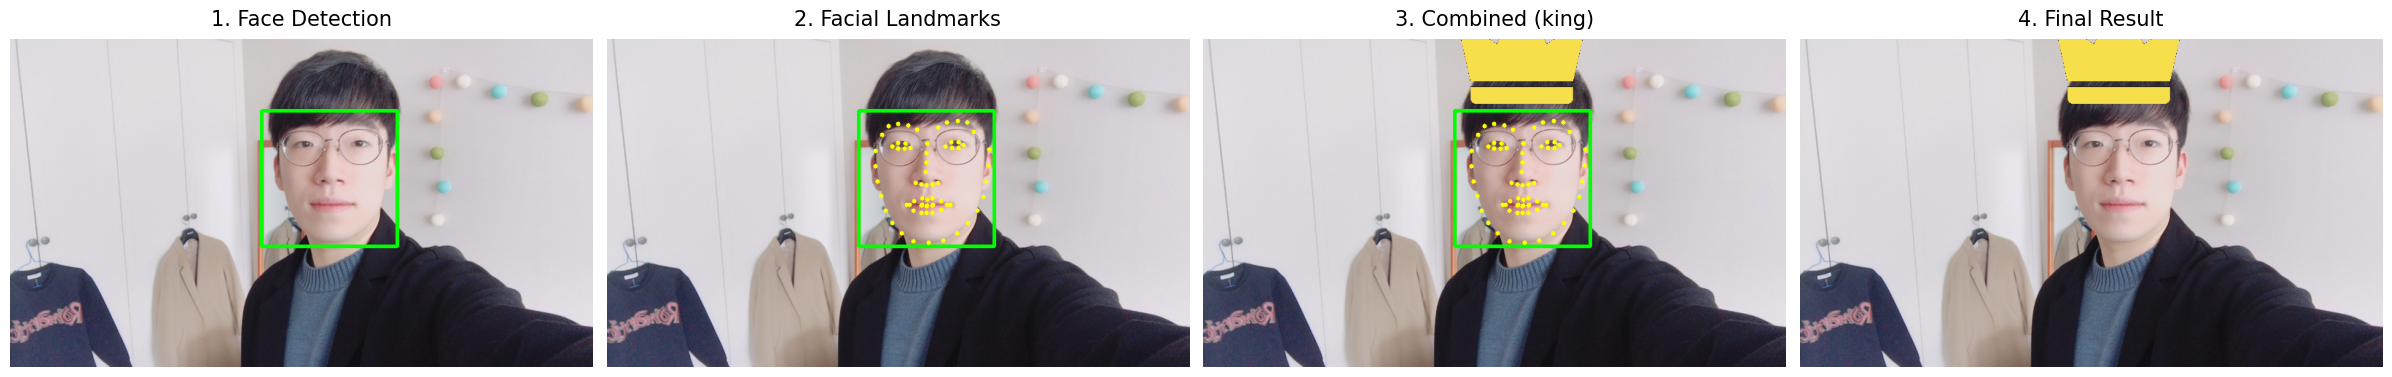

In [16]:
#왕관 스티커
processor.show_comparison_pipeline(image_file, sticker_paths, ['king'])

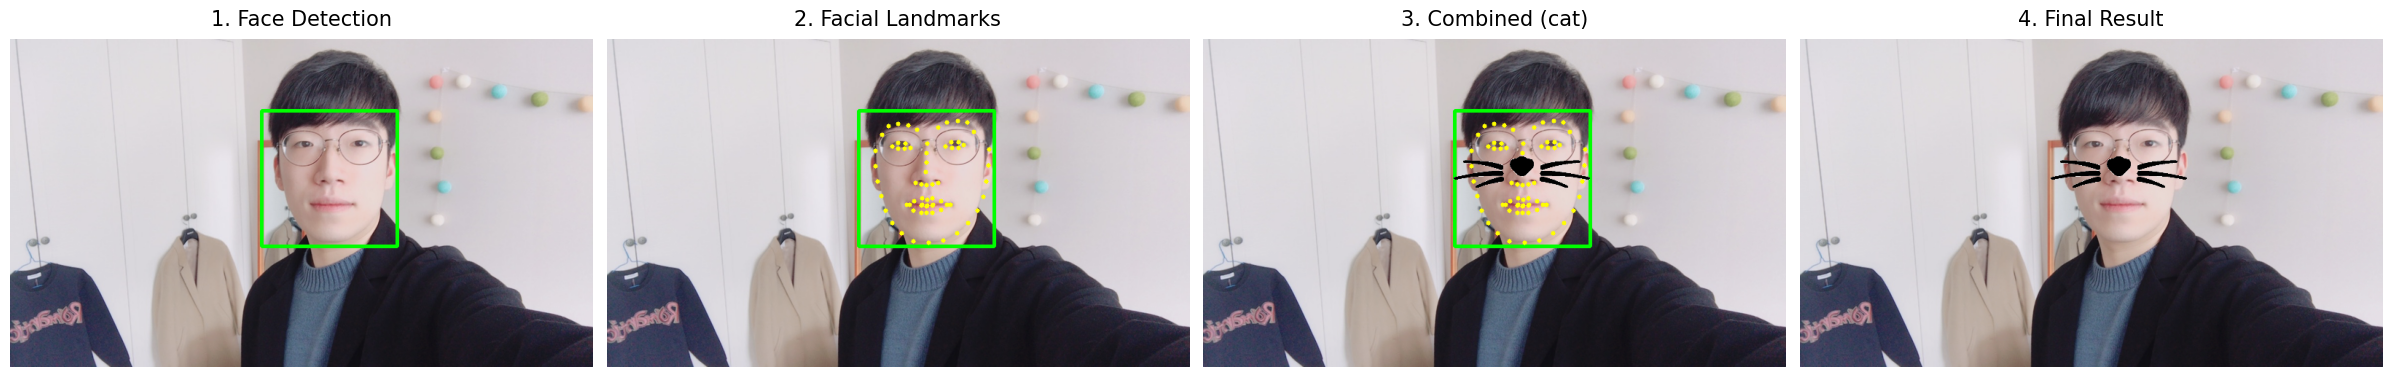

In [17]:
#고양이 스티커
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

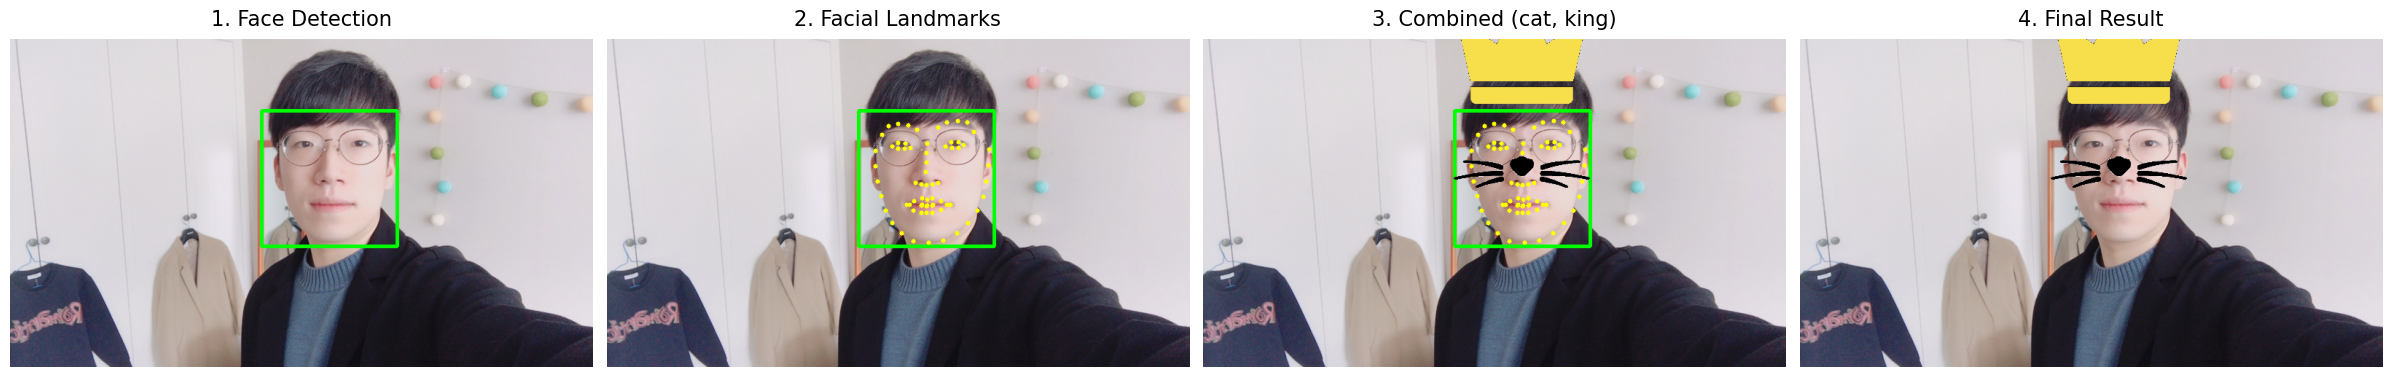

In [18]:
#고양이, 왕관 스티커
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat', 'king'])

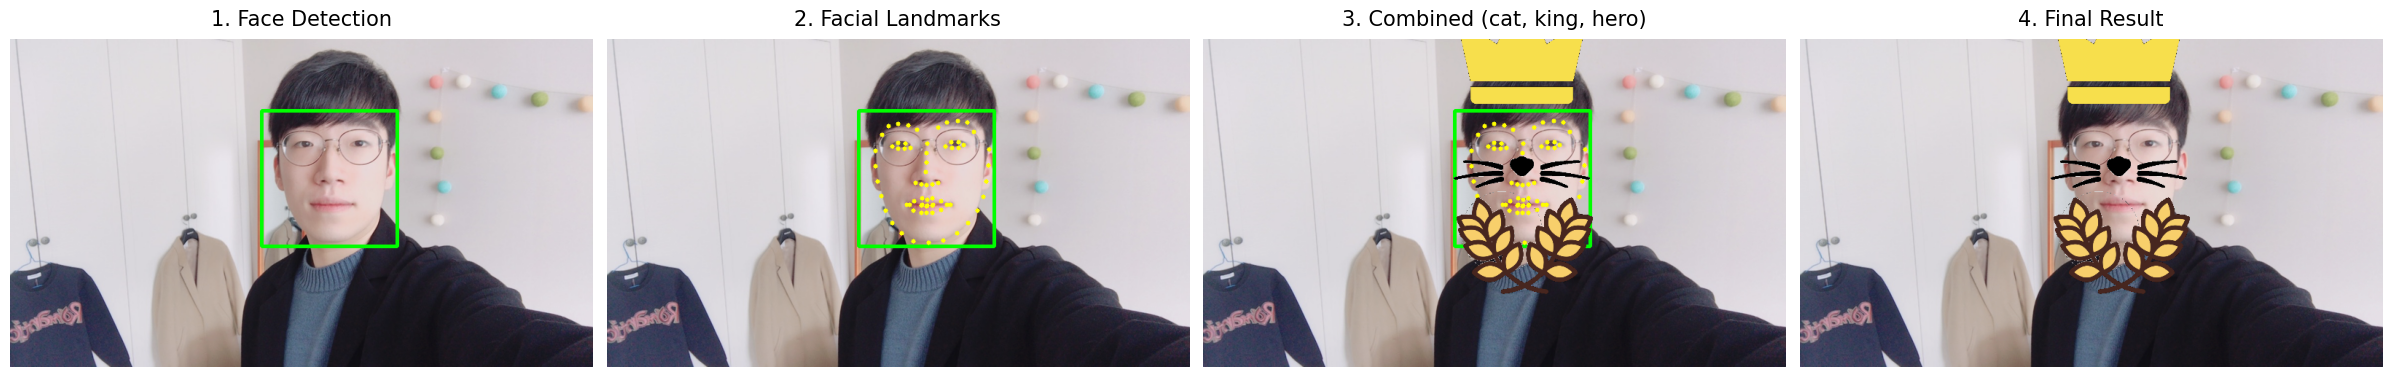

In [20]:
# 스티커
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat', 'king','hero'])

## 옆모습 탐지

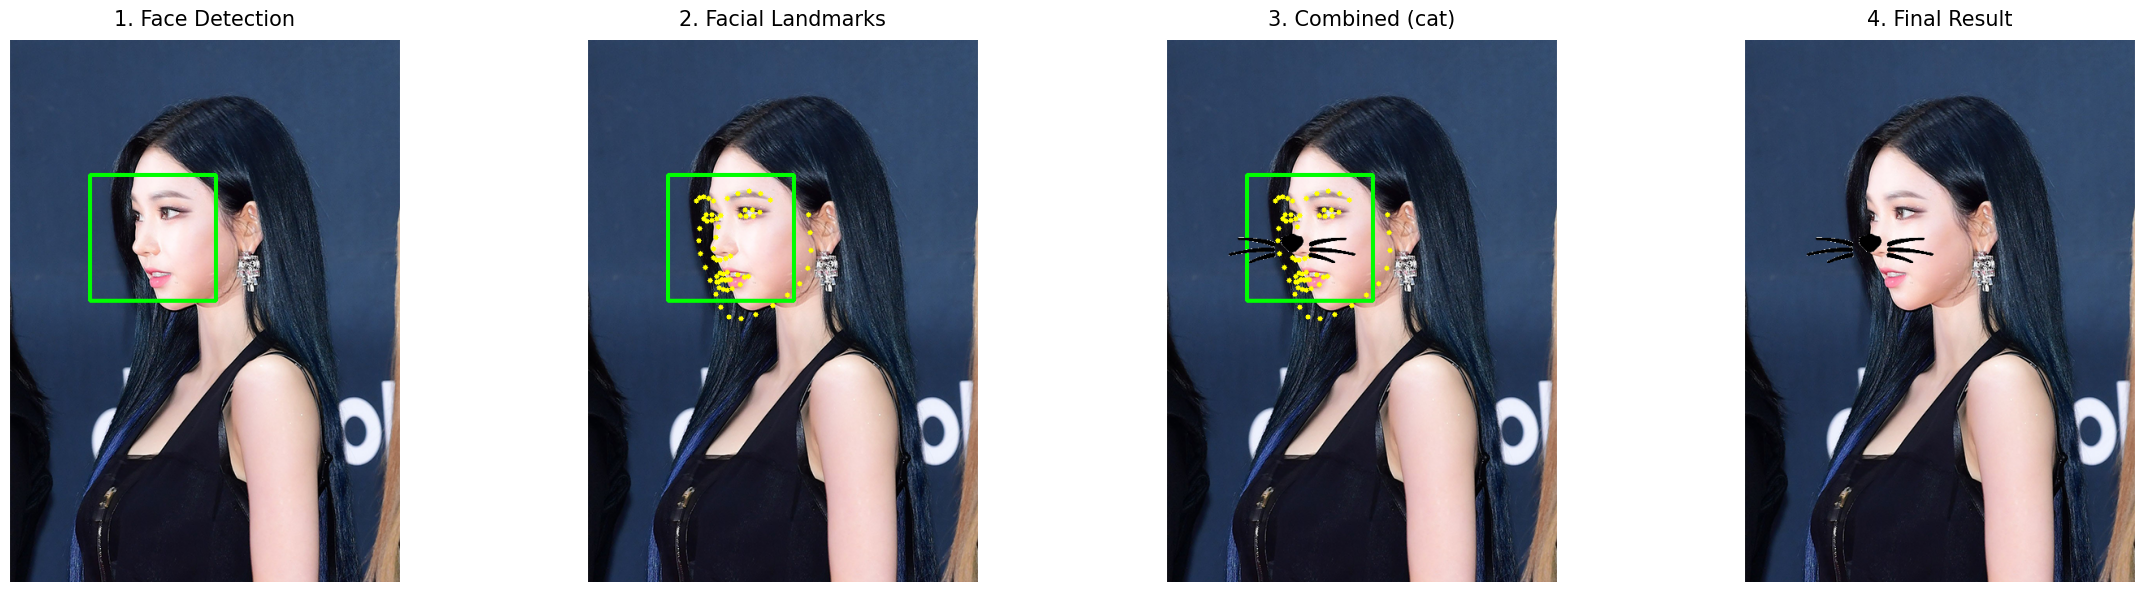

In [21]:
image_file = './images/karina4.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

# 단체 사진

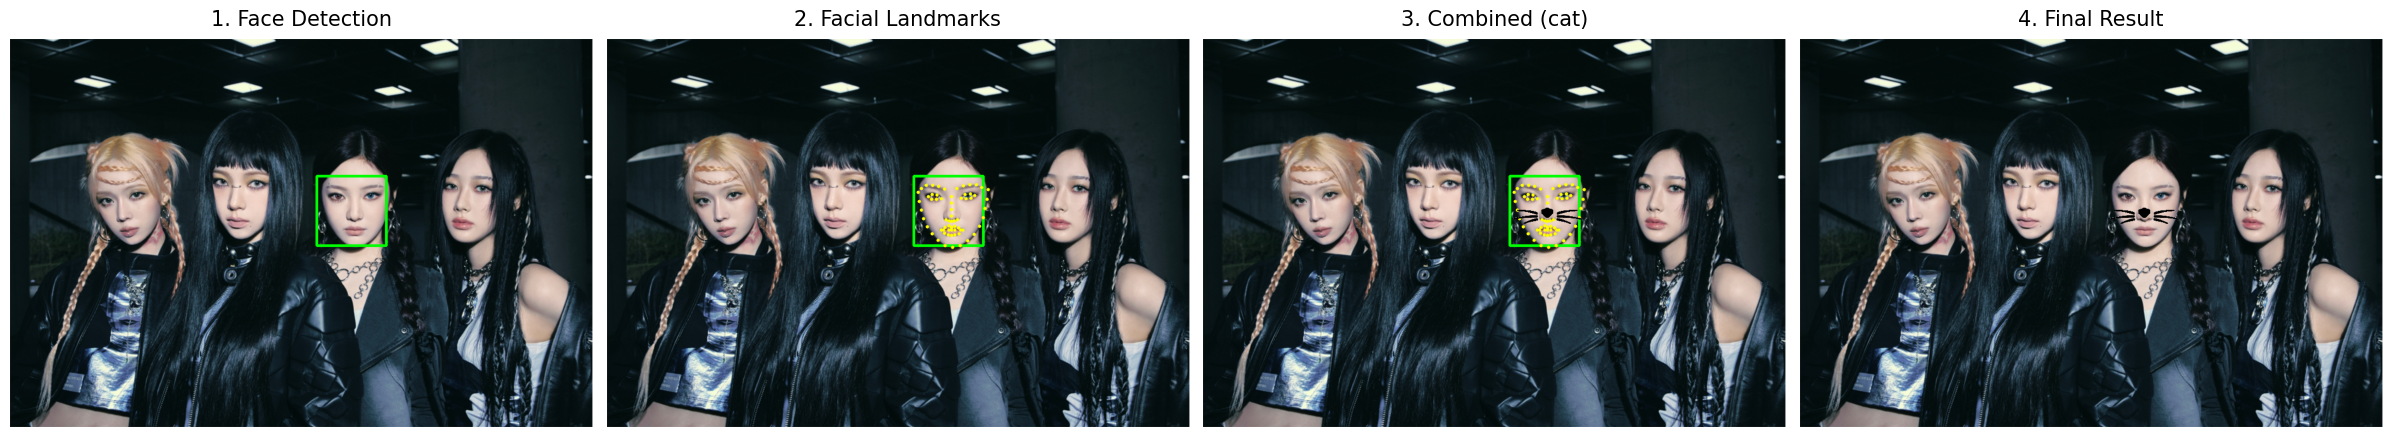

In [22]:
image_file = './images/aespa.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

## 캐릭터 - 2D

In [23]:
image_file = './images/conan.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

얼굴을 찾을 수 없습니다.


## 캐릭터 - 3D

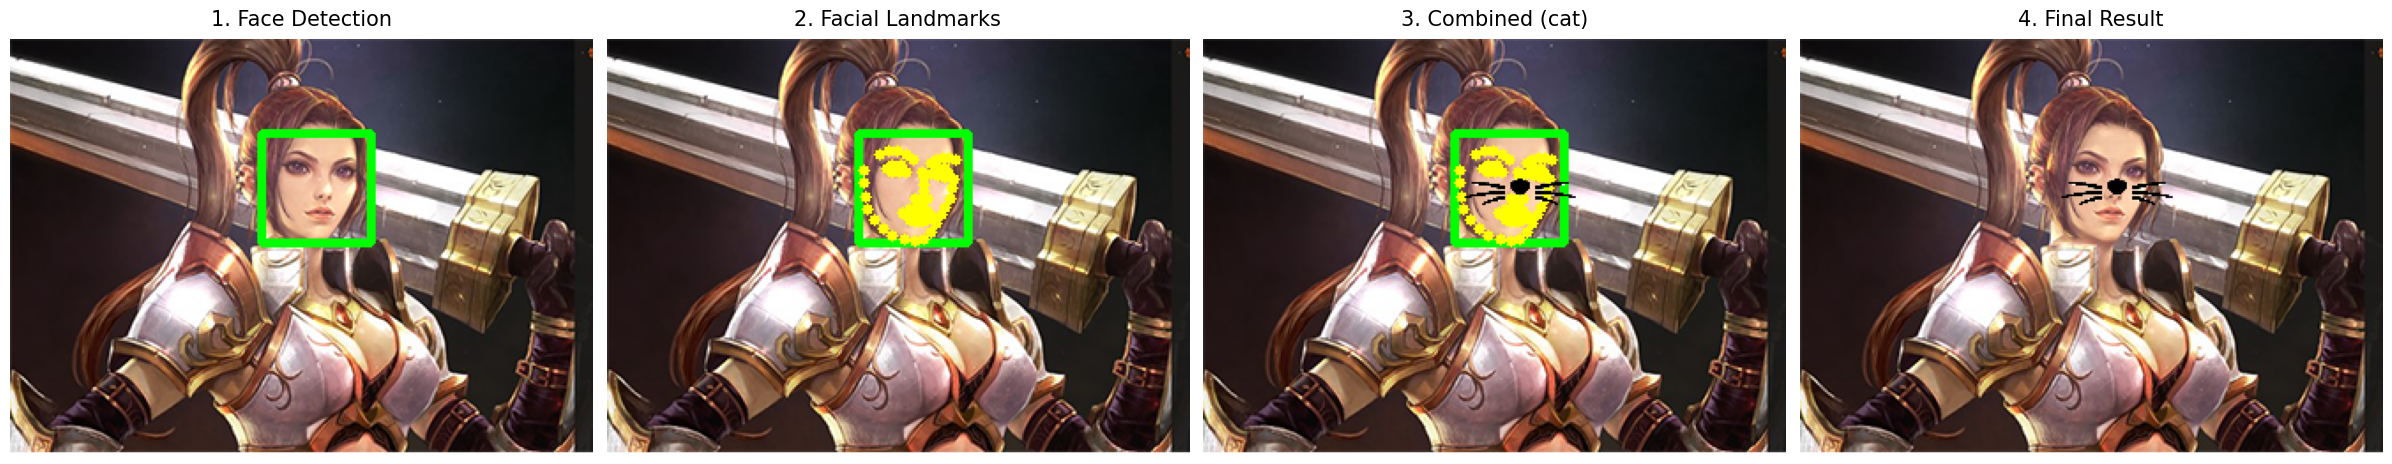

In [24]:
image_file = './images/lineage.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

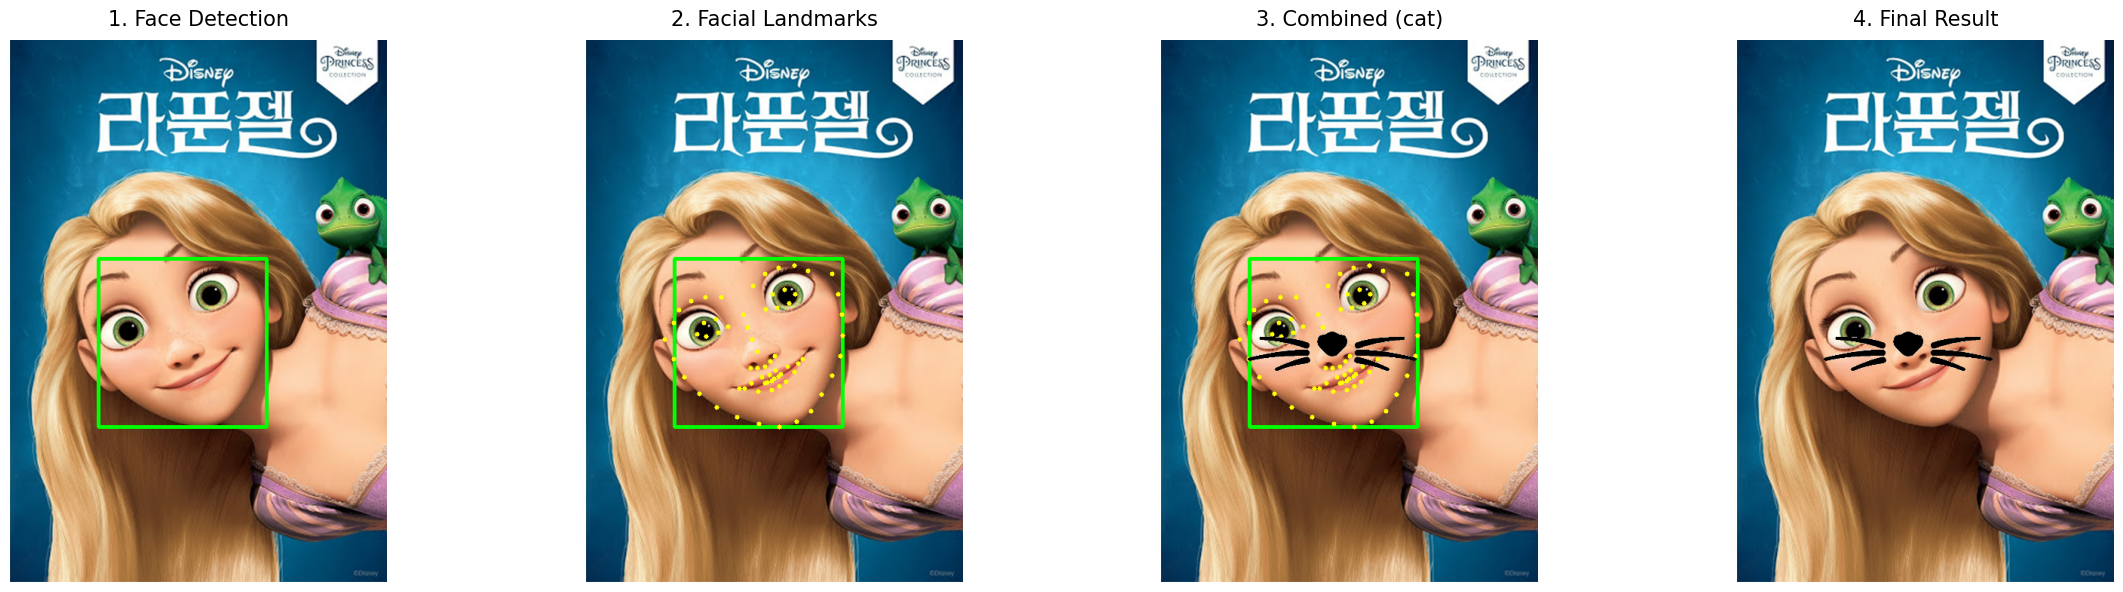

In [25]:
image_file = './images/Tangled.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

# 사진 각도

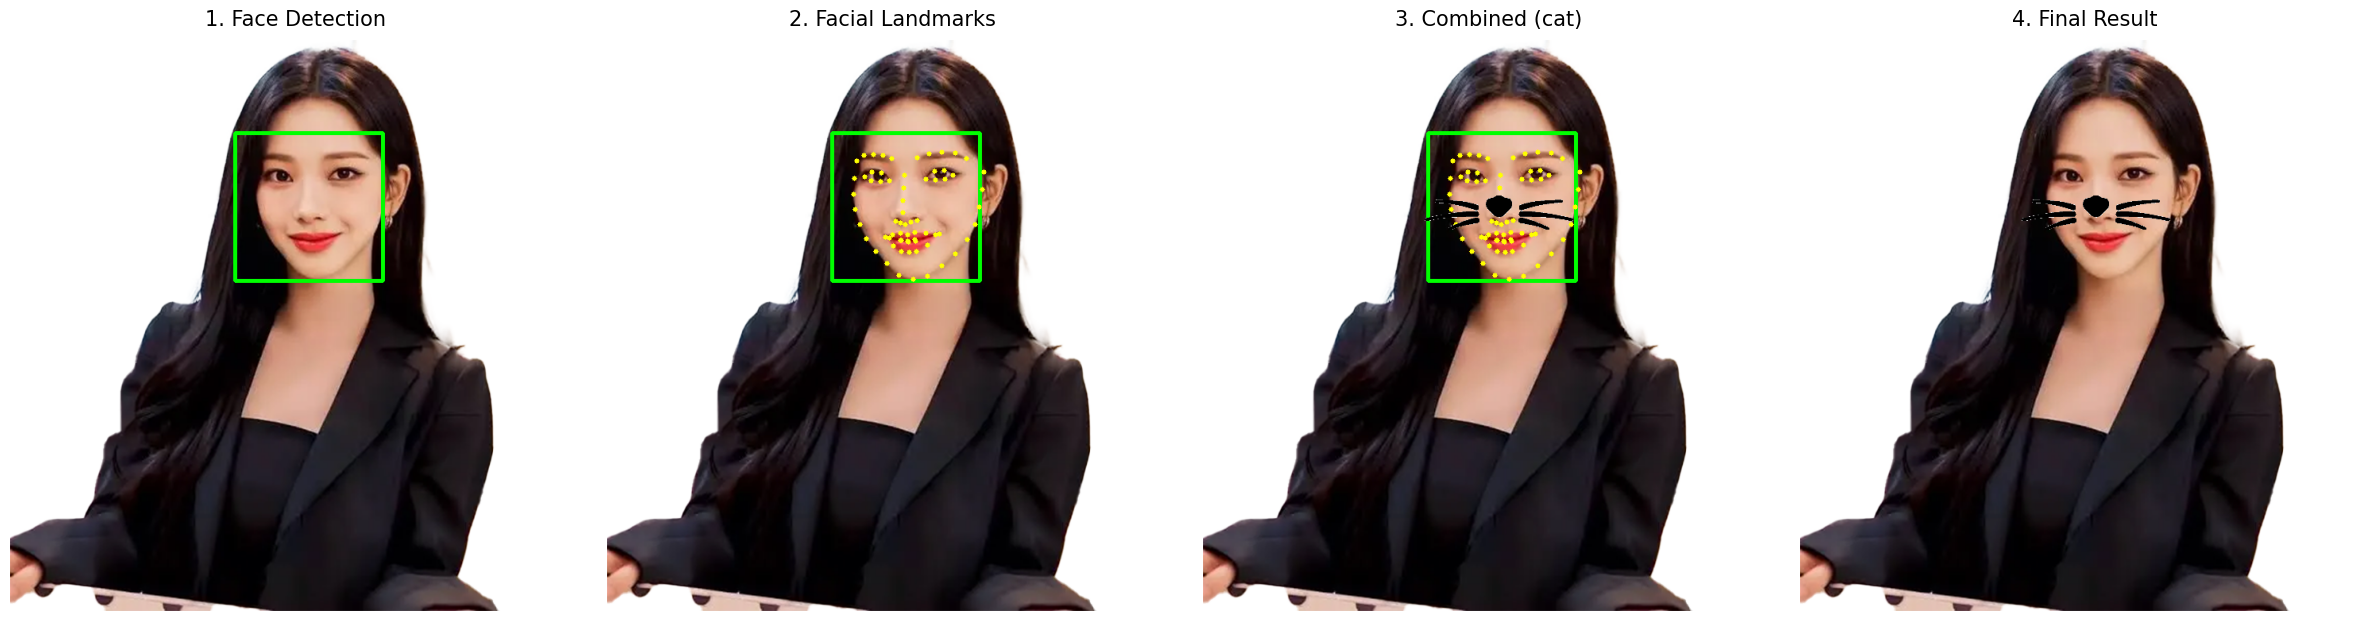

In [26]:
image_file = './images/karina1.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

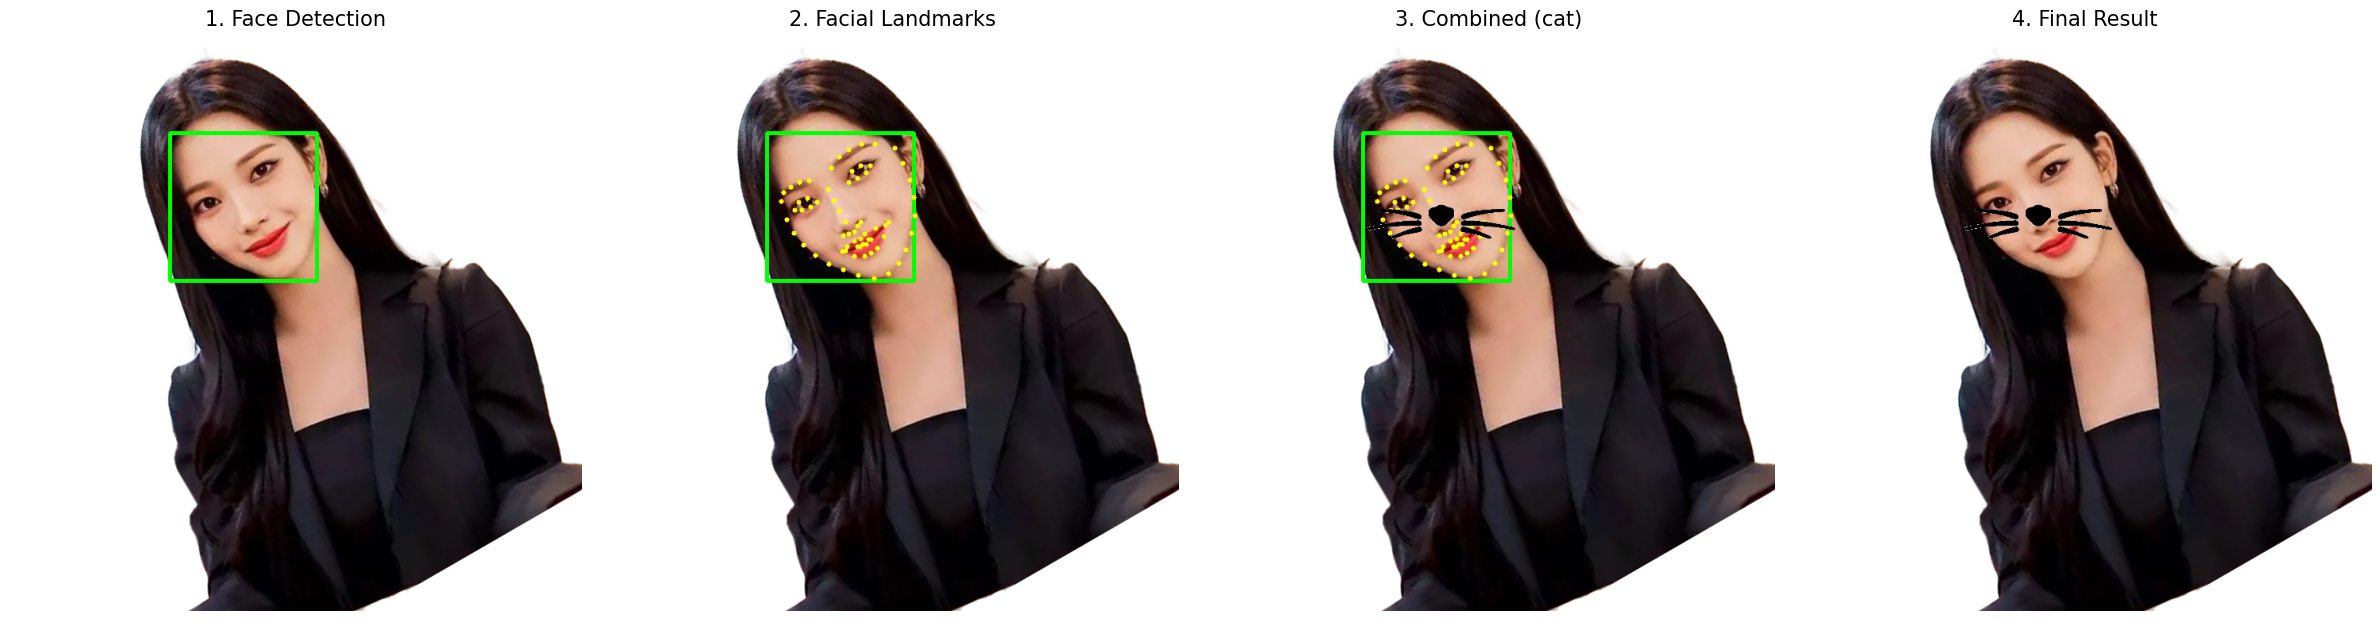

In [27]:
image_file = './images/karina1-30.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat'])

In [28]:
image_file = './images/karina1-45.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat', 'king'])

얼굴을 찾을 수 없습니다.


In [29]:
image_file = './images/karina1-90.png'
processor.show_comparison_pipeline(image_file, sticker_paths, ['cat', 'king'])

얼굴을 찾을 수 없습니다.
